In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
import math

# Get the Data

In [204]:
maneuvers = pd.read_csv("maneuvers.csv")
#maneuvers.head()

In [205]:
maneuvers.describe()

,t,x,y,z,dx,dy,dz,dv_st
count,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,359.000000,3.590000e+02
mean,627.495535,-0.990428,0.000026,-0.000171,0.000018,-0.000006,-0.000012,-3.540662e-07
std,363.802317,0.001022,0.003224,0.000730,0.002147,0.006612,0.001509,8.024838e-07
min,0.000000,-0.991674,-0.004533,-0.001185,-0.003250,-0.009049,-0.002170,-2.797266e-06
25%,313.747750,-0.991460,-0.003199,-0.000894,-0.001978,-0.006503,-0.001524,-8.970337e-07
50%,627.495500,-0.990595,0.000098,-0.000212,0.000020,-0.000344,-0.000054,-2.484375e-07
75%,941.243300,-0.989407,0.003279,0.000547,0.002014,0.006448,0.001498,2.173828e-07
max,1254.991000,-0.988843,0.004533,0.000944,0.003253,0.009959,0.002170,1.135547e-06


Notice that dv_vel varies in the range -2e-7 to 1e-7, while dv_st varies in the range -7e-9 to 4e-9, so the MOST COSTLY maneuvers are much larger using CORRECTION_VEL method than using CORRECTION_ST !!

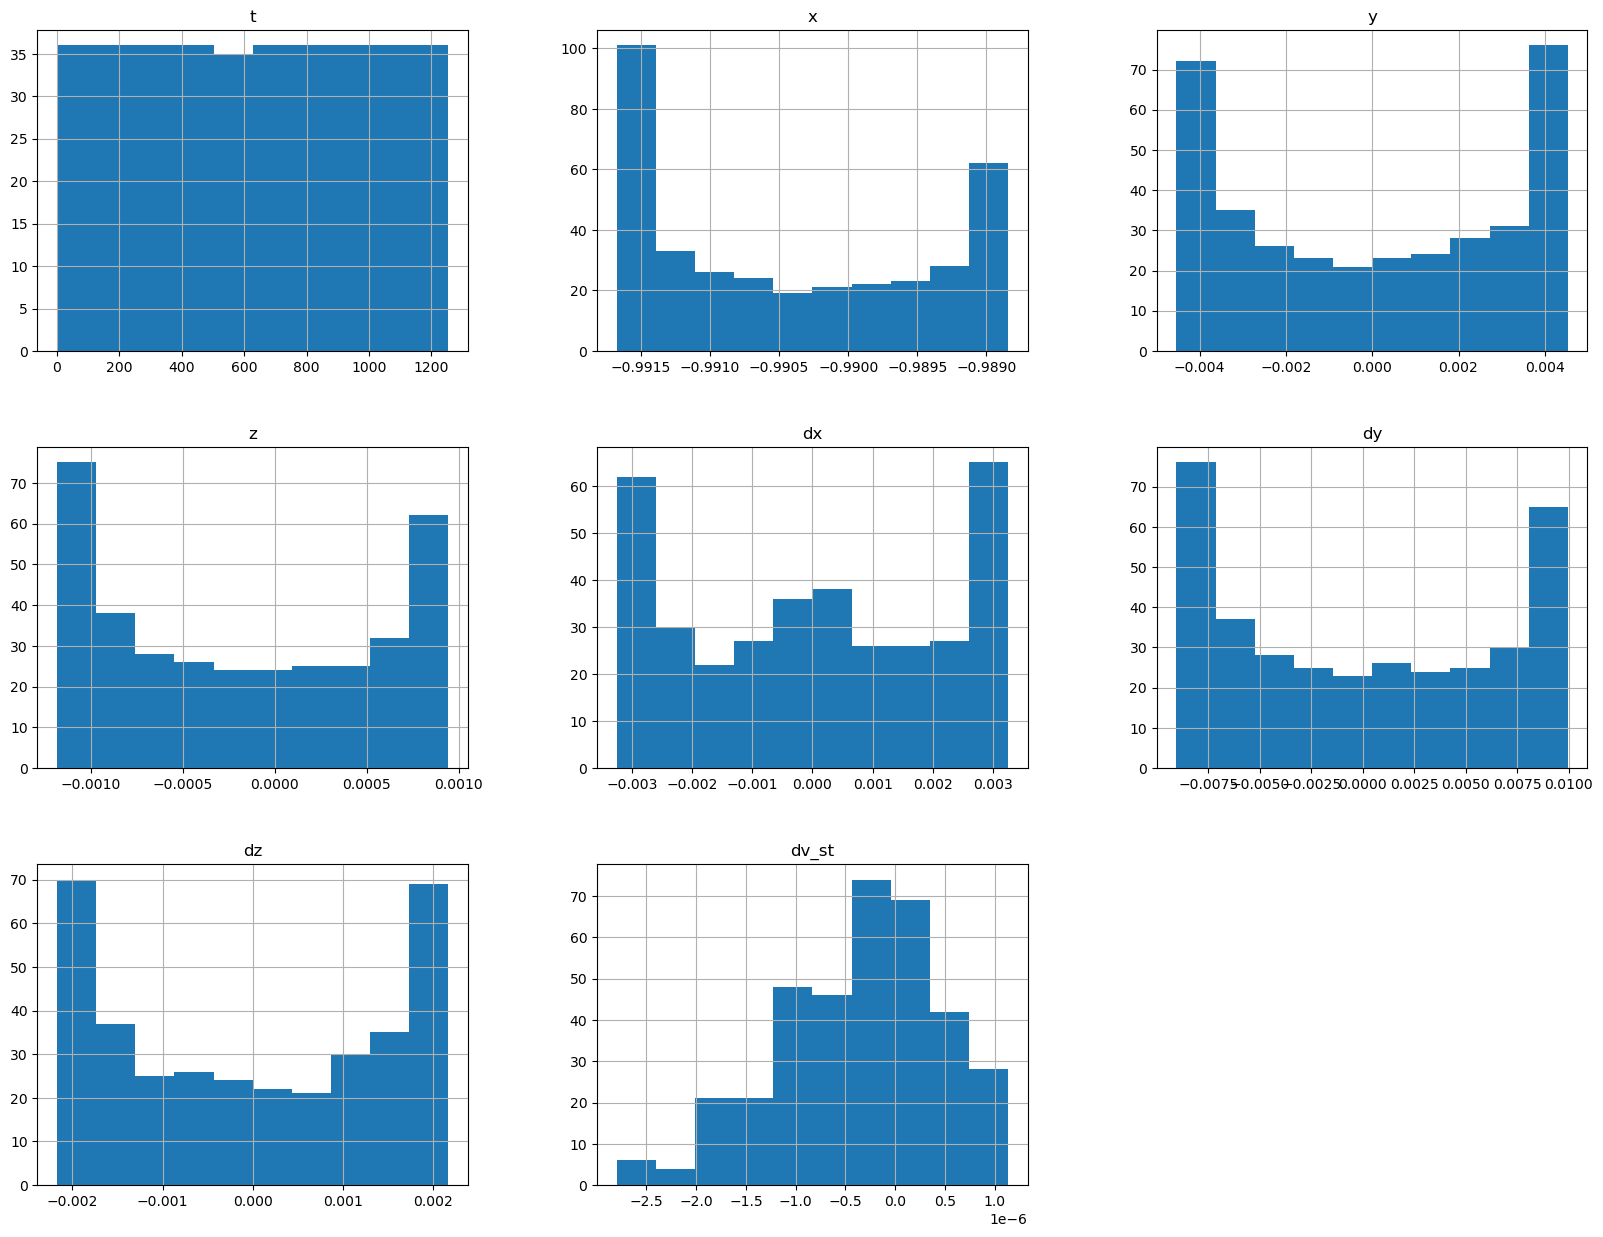

In [206]:
maneuvers.hist(figsize=(20,15))
plt.show()

Histograms of attributes (x,y,z,dx,dy,dz) are tail heavy. We may need to transform to polar coords, or use angle in p.o. as extra attribute.

## Create a Train/Test Set

In [207]:
train_set, test_set = train_test_split(maneuvers, test_size=0.2, random_state=1)

## Visualizing Data

In [208]:
# Let's create a copy of the training set and call it 'maneuvers' again.
# This way we can play around with it without harming the training set.
maneuvers = train_set.copy()

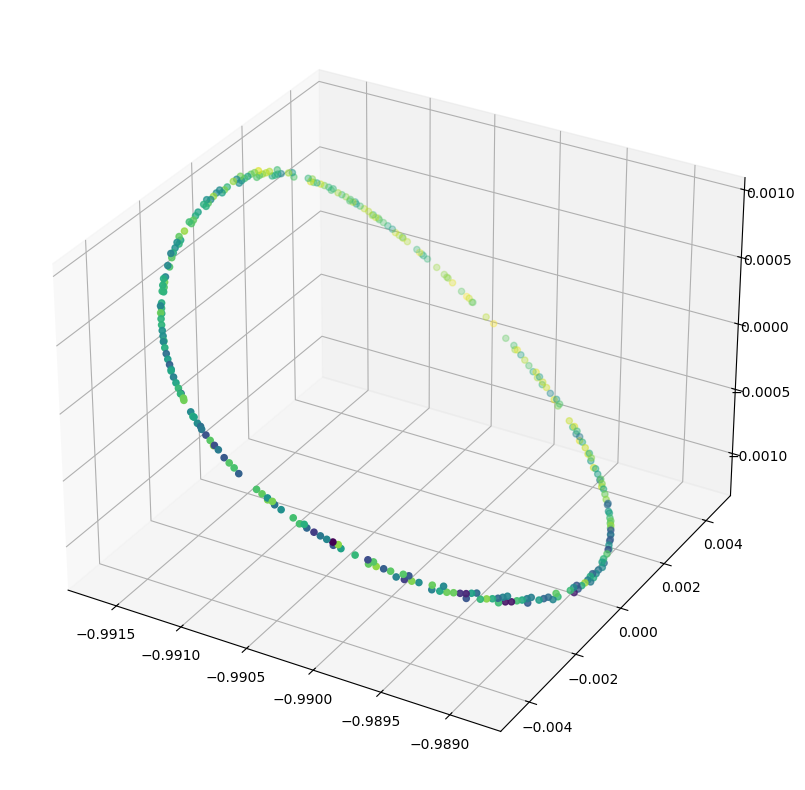

In [209]:
# Visualize shadowing orbit in position space, i.e. the points where correction
# maneuvers are performed.

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(maneuvers['x'], maneuvers['y'], maneuvers['z'], c=maneuvers['dv_st'])
plt.show()

Try adding new attribute "angle" = angle in the periodic orbit, which is essentially time/period.

In [210]:
maneuvers["angle"]=maneuvers["t"].apply(lambda x: math.fmod(x, 0.3059226605957322E+01))
maneuvers = maneuvers.drop(["t"], axis=1)
corr_matrix = maneuvers.corr()
corr_matrix["dv_st"].sort_values(ascending=False)

dv_st    1.000000
y        0.451442
dx       0.448482
dy       0.241838
z        0.239610
angle   -0.121239
x       -0.264715
dz      -0.445031
Name: dv_st, dtype: float64

array([[<Axes: xlabel='angle', ylabel='angle'>,
        <Axes: xlabel='x', ylabel='angle'>,
        <Axes: xlabel='dv_st', ylabel='angle'>],
       [<Axes: xlabel='angle', ylabel='x'>,
        <Axes: xlabel='x', ylabel='x'>,
        <Axes: xlabel='dv_st', ylabel='x'>],
       [<Axes: xlabel='angle', ylabel='dv_st'>,
        <Axes: xlabel='x', ylabel='dv_st'>,
        <Axes: xlabel='dv_st', ylabel='dv_st'>]], dtype=object)

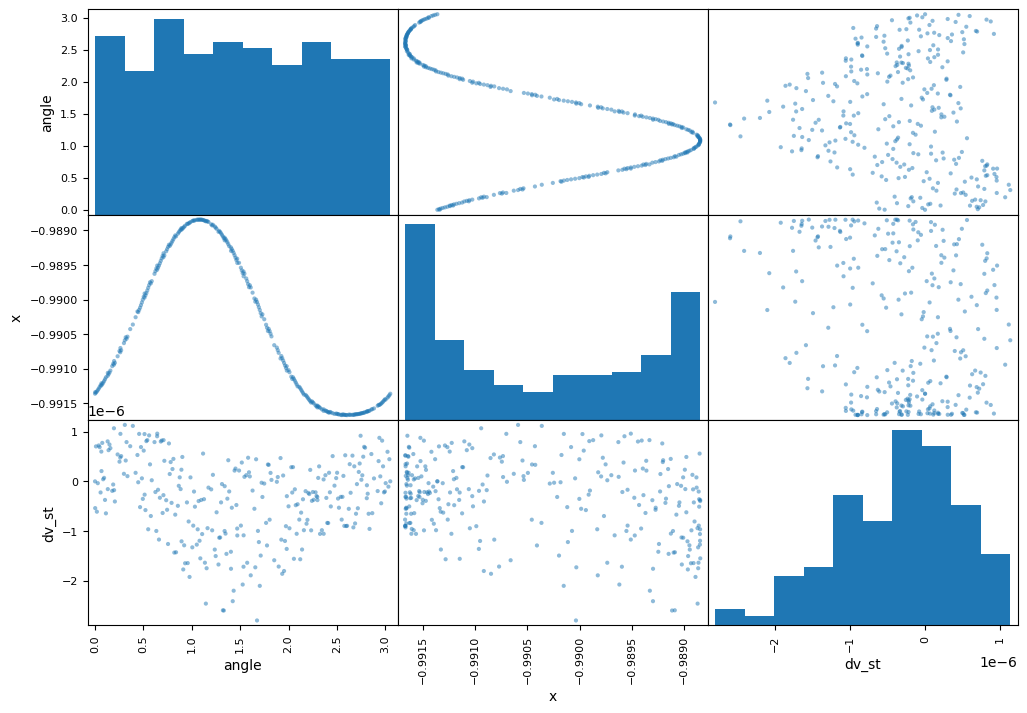

In [211]:
attributes = ["angle", "x", "dv_st"]
scatter_matrix(maneuvers[attributes], figsize=(12, 8))

dv_st is either positively or negatively correlated to state variables (x,y,z,dx,dy,dz) !!

Notice that angle and dv_st are not correlated, but they are nonlinearly related ("V" shape) !!

# Prepare the Data for Machine Learning Algorithms

In [212]:
# Let's separate the predictors and the labels
maneuvers_predictors = maneuvers.drop("dv_st", axis=1)
maneuvers_labels = maneuvers["dv_st"].copy()
maneuvers_predictors.head()
#maneuvers_labels.head()

,x,y,z,dx,dy,dz,angle
12,-0.991534,-0.002869,0.000642,-0.000987,0.007443,0.001505,2.296794
303,-0.989551,0.003458,-0.000839,0.002902,-0.005842,-0.001490,0.633368
119,-0.988846,-0.000230,-0.001143,-0.000211,-0.009031,0.000095,1.106982
358,-0.989330,0.002945,-0.000954,0.002549,-0.006879,-0.001258,0.708092
249,-0.988863,0.000612,-0.001162,0.000561,-0.008963,-0.000255,1.005317


# Select and Train a Model

## Training and Evaluating on the Training Set

In [213]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(maneuvers_predictors, maneuvers_labels)

LinearRegression()

In [214]:
# Let's measure this regression model's RMSE on the whole training set
from sklearn.metrics import mean_squared_error
maneuvers_predictions = lin_reg.predict(maneuvers_predictors)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6.681265419514353e-07

Clearly not a great score: the SD(dv_st) value is 8.e-7, so a typical prediction error of 6.6.e-7 is not great.

In [215]:
# Let’s train a DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = tree_reg.predict(maneuvers_predictors)
tree_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

2.542944262517854e-09

NOW THAT !!

In [216]:
#Let's try it out on 5 instances from the training set
some_data = maneuvers_predictors[10:20]
some_labels = maneuvers_labels[10:20]
print("Predictions:", tree_reg.predict(some_data))
print("Labels:", list(some_labels))

Predictions: [-6.4326170e-07  3.4609370e-07 -8.9648435e-07 -3.1171875e-07
 -2.4096680e-06 -4.9169920e-07 -1.5574220e-06  1.1015620e-07
 -8.3704835e-07 -9.8486330e-07]
Labels: [-6.432617e-07, 3.460937e-07, -8.984619e-07, -3.121094e-07, -2.409668e-06, -4.916992e-07, -1.557422e-06, 1.101562e-07, -8.356201e-07, -9.848633e-07]


In [217]:
# Let’s train a RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(maneuvers_predictors, maneuvers_labels)

maneuvers_predictions = forest_reg.predict(maneuvers_predictors)
forest_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

2.8680477450744596e-07

## Polynomial Regression

In [218]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
maneuvers_pred_poly = poly_features.fit_transform(maneuvers_predictors)
#print(maneuvers_predictors.head())
#print(maneuvers_pred_poly[0])

In [219]:
lin_reg = LinearRegression()
lin_reg.fit(maneuvers_pred_poly, maneuvers_labels)
maneuvers_predictions = lin_reg.predict(maneuvers_pred_poly)
lin_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.4976741289419794e-07

## SVM Regression

In [220]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2)
svm_poly_reg.fit(maneuvers_predictors, maneuvers_labels)
maneuvers_predictions = svm_poly_reg.predict(maneuvers_predictors)
svm_mse = mean_squared_error(maneuvers_labels, maneuvers_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

9.354259451113103e-07